#<div align="center">Sequence to Sequence</div>

---
###### Author     : alvinwatner
###### Inspired by : Aladdin Persson (https://www.youtube.com/watch?v=EoGUlvhRYpk&t=2146s)
---

##To reproduce : 

1.   Make sure you have utils.py inside your google drive, otherwise there are 2 ways to acquire utils.py file :

  *   Open and Run the [utils.ipynb](https://colab.research.google.com/drive/1tkh9NyoKLfl4gk8L3_JKVGfCMIXDLy37?usp=sharing).
  *   Download from this [link](https://drive.google.com/file/d/18RMp42VvfMSdUfxxYKR_1QiA5fWcbgus/view?usp=sharing).

  Also make sure the **utils.py** is inside the **main_path** directory that specified on the *second cell*.


2. Create "**Checkpoint**" folder inside the **main_path**.
3. Create "**plot**" folder inside the **main_path** .






<br/>

---

###### *Note : Don't forget to change runtime type to **GPU**, and **CTRL + F9** to run all cells, otherwise the training will run super slow. Enjoy~*

In [28]:
# Mount to gdrive and have a peek to current path
from google.colab import drive 
drive. mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Main path for tensorboard and checkpoint
main_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Pytorch/Seq2seq/'

In [30]:
# Path to utils.py root folder
%cd /content/drive/MyDrive/Colab Notebooks/NLP/Pytorch/Seq2seq

/content/drive/MyDrive/Colab Notebooks/NLP/Pytorch/Seq2seq


In [31]:
# Make sure the utils.py is inside the main_path directory that specified on the second cell.
!ls -l utils.py

-rw------- 1 root root 2415 Dec 23 03:36 utils.py


In [32]:
#import utils.py as module
from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import numpy as np 
import random
import spacy
import matplotlib.pyplot as plt

import datetime
import os

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda


In [ ]:
!pip install torchtext==0.6.0 
!python -m spacy download de #Language degerman
!python -m spacy download en #Language enlish

In [35]:
spacy_ger = spacy.load('de')
spacy_en  = spacy.load('en')

In [36]:
def tokenizer_ger(text):
  return [tok.text for tok in spacy_ger.tokenizer(text)]

def tokenizer_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [37]:
gerField = Field(tokenize = tokenizer_ger, lower = True, \
                 init_token = '<SOS>', eos_token = '<EOS>')

enField = Field(tokenize = tokenizer_en, lower = True, \
                 init_token = '<SOS>', eos_token = '<EOS>')

In [38]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (gerField, enField))

In [39]:
gerField.build_vocab(train_data, max_size = 10000, min_freq = 2)
enField.build_vocab(train_data, max_size = 10000, min_freq = 2)

In [40]:
encoder_input_size = len(gerField.vocab)
decoder_input_size = len(enField.vocab)
num_layers = 2
hidden_size = 1024
batch_size = 32
embedding_dim = 300
dropout = 0.5
num_epochs = 10

In [41]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = batch_size,
    sort_within_batch = True,
    sort_key = lambda x : len(x.src),
    device = device
)

In [42]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_dim, hidden_size, num_layers, dropout):
    super().__init__()
    self.num_layers = num_layers
    self.embedding  = nn.Embedding(input_size, embedding_dim)
    self.rnn        = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout = dropout)
    self.dropout    = nn.Dropout(dropout)
  
  def forward(self, inp):
    #inp.shape         = (seq_length, batch_size)
    embedded           = self.dropout(self.embedding(inp))
    #embedded.shape    = (seq_length, batch_size, embedding_dim) 
    _ , (hidden, cell) = self.rnn(embedded)
    #hidden.shape      = (num_layers, batch_size, embedding_dim)
    #cell.shape        = (num_layers, batch_size, embedding_dim)
    return hidden, cell

In [43]:
class Decoder(nn.Module):
  def __init__(self, input_size, embedding_dim, hidden_size, num_layers, dropout):
    super().__init__()
    vocab_size      = input_size
    self.embedding  = nn.Embedding(vocab_size, embedding_dim)
    self.rnn        = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout = dropout)
    self.fc         = nn.Linear(hidden_size, vocab_size)
    self.dropout    = nn.Dropout(dropout)

  def forward(self, inp, hidden, cell):
    #inp.shape             = (batch_size,)
    inp                    = inp.unsqueeze(0)
    #inp.shape             = (1, batch_size)
    embedded               = self.dropout(self.embedding(inp) )
    #embedded.shape        = (1, batch_size, embedding_dim)
    out_de, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    #out_de                = (1, batch_size, hidden_size)
    #hidden                = (num_layers, batch_size, hidden_size)
    #cell                  = (num_layers, batch_size, hidden_size)

    out_de                 = self.fc(out_de)
    #out_de                = (1, batch_size, vocab_size)
    out_de                 = out_de.squeeze(0)
    #out_de                = (1, batch_size, vocab_size)

    return out_de, hidden, cell


In [44]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder 
    self.decoder = decoder

  def forward(self, source, target, tfr = 0.5):  
    #source.shape = (seq_length, batch_size) 
    #target.shape = (seq_length, batch_size) 
    seq_length    = target.shape[0]
    batch_size    = target.shape[1]
    vocab_size    = len(enField.vocab)
    outputs       = torch.zeros(seq_length, batch_size, vocab_size).to(device)

    # init_token = <SOS>
    inp = target[0]
    #inp.shape = (32,)

    hidden, cell = self.encoder(source)
    
    for t in range(1, seq_length):
      output, hidden, cell = self.decoder(inp, hidden, cell)
      #output.shape        = (batch_size, vocab_size)
      #hidden.shape        = (batch_size, vocab_size) 

      outputs[t] = output

      best_guess = output.argmax(1)
      
      inp = best_guess if random.random() > tfr else target[t]

    return outputs

In [45]:
encoder = Encoder(encoder_input_size, embedding_dim, hidden_size, num_layers, dropout).to(device)
decoder = Decoder(decoder_input_size, embedding_dim, hidden_size, num_layers, dropout).to(device)
seq2seq = Seq2Seq(encoder, decoder).to(device)

In [46]:
pad_idx   = enField.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(seq2seq.parameters(), lr = 0.001)

In [47]:
plot_ = {'avg_loss' : [], 'epoch' : []}

In [48]:
load_model = False

if load_model:
  model_name    = 'PerssonSeq2seq'
  current_epoch = 0
  path = f"{main_path}/Checkpoint/|Model_{model_name}|Epoch_{current_epoch}.pth.tar"
  load_checkpoint(torch.load(path), seq2seq, optimizer)
else:
  model_name = 'Seq2Seq'
  current_epoch = 0

In [49]:
import datetime
import pytz

time_zone = pytz.timezone('Asia/Jakarta')

def delta_time(start_time, stop_time):
  delta_time = stop_time - start_time
  minute, second = divmod(delta_time.total_seconds(), 60)  
  hour, minute   = divmod(minute, 60)  

  return int(hour), int(minute), int(second)

In [50]:
start_time = datetime.datetime.now(time_zone)

for epoch in range(num_epochs):
  epoch_loss     = 0
  iteration_loss = [] 

  for batch_idx, batch in enumerate(train_iterator):
    source = batch.src.to(device)
    target = batch.trg.to(device)

    outputs = seq2seq(source, target)
    outputs = outputs[1:].reshape(-1, outputs.shape[2])
    ground_Truth = target[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(outputs, ground_Truth)
    loss.backward()
    torch.nn.utils.clip_grad_norm(seq2seq.parameters(), max_norm = 1)
    optimizer.step()
    loss_val = loss.item()
    iteration_loss.append(loss_val)

    epoch_loss += loss_val

    # Average loss for the last 100 iteration         
    if not batch_idx % 100 and batch_idx != 0:
      print(f"EPOCH : {epoch}/{num_epochs - 1} || Batch Iteration : {batch_idx}/{len(train_iterator)} || Avg_Loss from {batch_idx - 100} to {batch_idx} : {sum(iteration_loss[-100:])/100}") 
  
  
  avg_loss = epoch_loss/len(train_iterator)
  plot_['avg_loss'].append(avg_loss)
  plot_['epoch'].append(epoch)

  # Save Current Checkpoint and Plot
  checkpoint = {'state_dict' : seq2seq.state_dict(), 'optimizer': optimizer.state_dict()}
  save_checkpoint(checkpoint, 
                  filename=f"{main_path}Checkpoint/|Model_{model_name}|Epoch_{current_epoch}.pth.tar")  
  
  np.save(f"{main_path}plot/AvgLoss_Model_{model_name}|Epoch_{current_epoch}", \
                              np.array(plot_['avg_loss']))  
  np.save(f"{main_path}plot/Epoch_Model_{model_name}|Epoch_{current_epoch}", \
                              np.array(plot_['epoch']))  

  # Remove Previous Checkpoint and Plot
  if epoch > 0:
    os.remove(f"{main_path}Checkpoint/|Model_{model_name}|Epoch_{current_epoch - 1}.pth.tar")    
    os.remove(f"{main_path}plot/AvgLoss_Model_{model_name}|Epoch_{current_epoch - 1}.npy")
    os.remove(f"{main_path}plot/Epoch_Model_{model_name}|Epoch_{current_epoch - 1}.npy")

  if epoch == num_epochs - 1:
    stop_time = datetime.datetime.now(time_zone)
    hour, minute, second = delta_time(start_time, stop_time)

    print("")
    print(f" **************  TRAINING DONE {num_epochs} EPOCHS  ************")
    print(f" **********  {hour} Hours, {minute} Minutes, {second} Seconds  ********")        
    print(" ====================================================")  
    print(f"|              Average Loss : {avg_loss}     |")   
    print(" ====================================================") 

  else:
    print(f" ************** EPOCH - {epoch}/{num_epochs - 1} **************")
    print(f"|       Average Loss : {avg_loss}           |")   
    print(" ********************************************")         
    print("")

  current_epoch += 1    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


EPOCH : 0/9 || Batch Iteration : 100/907 || Avg_Loss from 0 to 100 : 5.186486873626709
EPOCH : 0/9 || Batch Iteration : 200/907 || Avg_Loss from 100 to 200 : 4.782468976974488
EPOCH : 0/9 || Batch Iteration : 300/907 || Avg_Loss from 200 to 300 : 4.663192913532257
EPOCH : 0/9 || Batch Iteration : 400/907 || Avg_Loss from 300 to 400 : 4.474164125919342
EPOCH : 0/9 || Batch Iteration : 500/907 || Avg_Loss from 400 to 500 : 4.398435051441193
EPOCH : 0/9 || Batch Iteration : 600/907 || Avg_Loss from 500 to 600 : 4.203316080570221
EPOCH : 0/9 || Batch Iteration : 700/907 || Avg_Loss from 600 to 700 : 4.158723690509796
EPOCH : 0/9 || Batch Iteration : 800/907 || Avg_Loss from 700 to 800 : 4.076728720664978
EPOCH : 0/9 || Batch Iteration : 900/907 || Avg_Loss from 800 to 900 : 3.9998026132583617
=> Saving checkpoint
 ************** EPOCH - 0/9 **************
|       Average Loss : 4.441307349662402           |
 ********************************************

EPOCH : 1/9 || Batch Iteration : 100

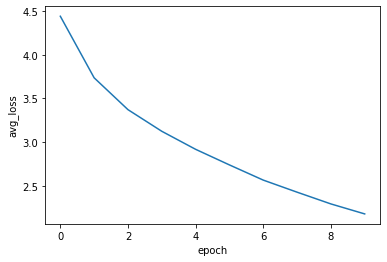

In [51]:
#source  
plt.plot(plot_['epoch'], plot_['avg_loss'])
plt.xlabel('epoch')
plt.ylabel('avg_loss')
plt.show()